In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1'
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
import sys
sys.path.append("../src")

import visualpipe.post_analysis.Response_clustering as rclust
import visualpipe.post_analysis.utils as utils

import warnings
warnings.filterwarnings('ignore')

# Cluster stimuli responses

## Input

In [2]:
excel_sheet_path = "../src/visualpipe/post_analysis/Nathan_sessions.xlsx"
save_path = "C:/Users/mai-an.nguyen/Documents/test"

# Will be included in all names of saved figures
fig_name = 'static-patch-0deg-together-PositiveOnly'

# Name of the protocol to analyze (e.g. 'surround-mod', 'visual-survey'...)
protocol_name = 'vision-survey'

# Write the stimulus type you want to use for clustering
sub_protocol = 'static-patch-0'

attr='z-scores' # 'z-scores' or 'dFoF0-baseline'

# Frame rate
frame_rate = 30

# Maximum numbers of clusters
max_clusters = 10

## Process groups

In [3]:
df = utils.load_excel_sheet(excel_sheet_path, protocol_name)

groups_id = {'WT': 0, 'KO': 1}

normalized_traces_groups, single_traces_groups, magnitude_groups, response_mean_groups, all_neurons_groups, mouse_avg_zscore_groups, mouse_sem_zscore_groups = rclust.process_group(df, groups_id, sub_protocol, frame_rate, attr=attr)

Genotype : ['KO' 'WT']
Mice included : [109 112 108 110]

-------------------------- Processing WT group --------------------------

Session id: 2025_03_07_17-04-48
  Mouse id : 108
     Session path: Y:\raw-imaging\Nathan\2025_03_07\TSeries-03072025-016\2025_03_07_17-04-48_output_2
    Proportion of static-patch-0 responding neurons: 20.883534136546185

Session id: 2025_03_03_17-14-33
  Mouse id : 110
     Session path: Y:\raw-imaging\Nathan\PYR\110 male\Visual\03_03_2025\TSeries-03032025-006\2025_03_03_17-14-33_output_2
    Proportion of static-patch-0 responding neurons: 13.836477987421384

Number of WT neurons: 74

-------------------------- Processing KO group --------------------------

Session id: 2025_03_04_14-16-25
  Mouse id : 109
     Session path: Y:\raw-imaging\Nathan\PYR\109 male\Visual\2025_03_04\TSeries-03042025-010\2025_03_04_14-16-25_output_1
    Proportion of static-patch-0 responding neurons: 23.853211009174313

Session id: 2025_03_07_15-05-06
  Mouse id : 109
     

## Cluster the two groups separately

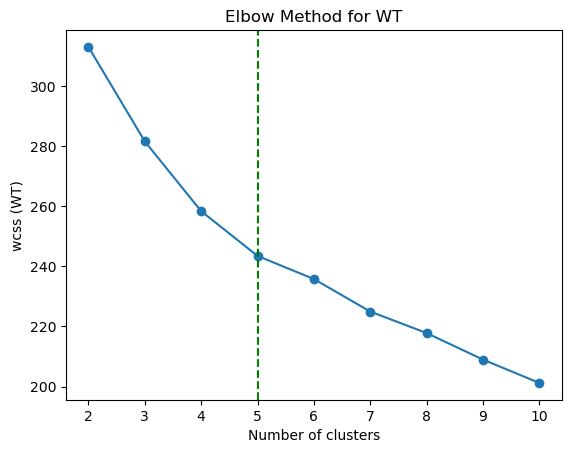

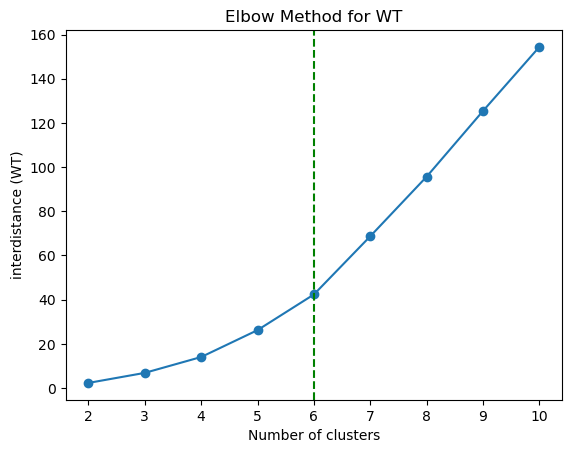

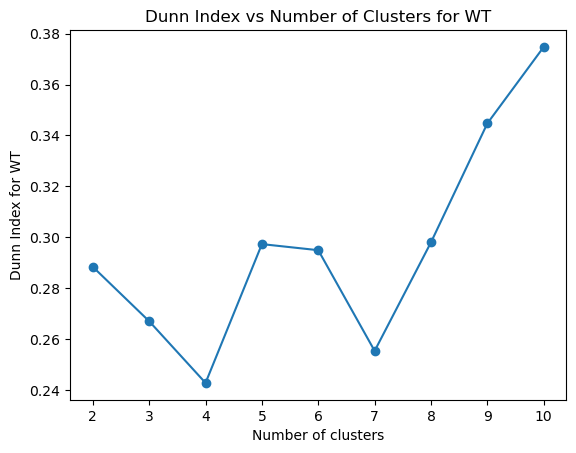

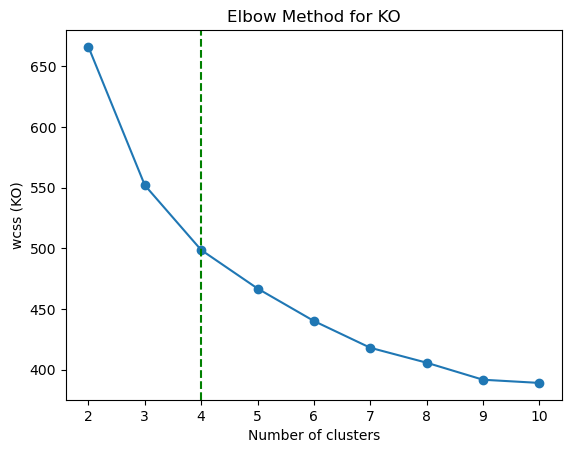

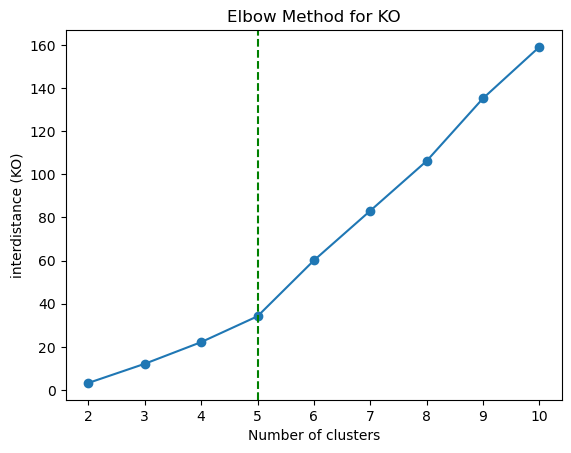

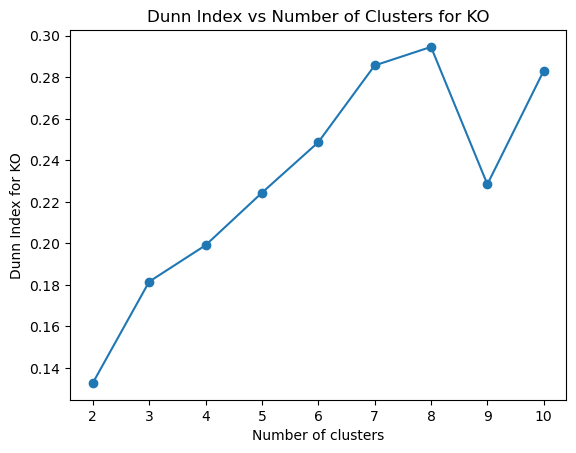

In [4]:
#To determine the ideal number of clusters
for group in groups_id.keys():
    traces = normalized_traces_groups[groups_id[group]]
    rclust.find_nb_clusters(traces, max_clusters=max_clusters, save_path=save_path, fig_name=fig_name, group=group, show=True)

### Choose a number of clusters for each group and visualize them

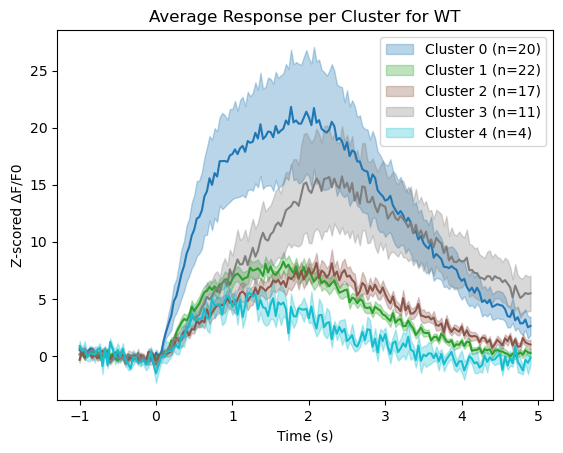

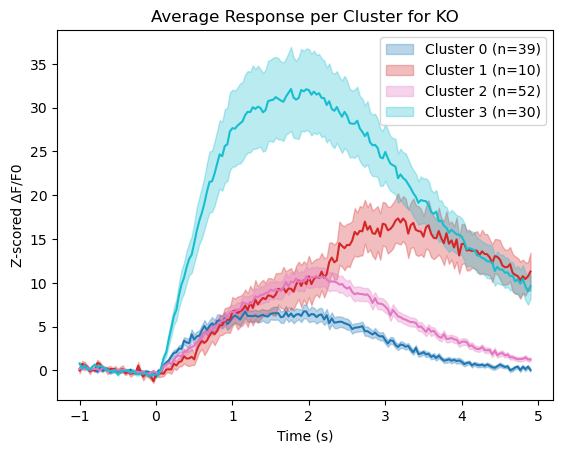

In [5]:
# Choose a number of clusters
k_clusters = {'WT': 5, 'KO': 4}  # Example: you can set different numbers for each group

# Dictionaries to store cluster mean and SEM for each group
cluster_data = {'WT': {}, 'KO': {}}
time = (np.arange(single_traces_groups[0].shape[1]) / frame_rate) -1 
xticks = np.arange(-1, time[-1] + 1, 1)  # ticks every 1 second

for group in groups_id.keys():
    norm = normalized_traces_groups[groups_id[group]]
    traces = single_traces_groups[groups_id[group]]
    nclusters = k_clusters[group]

    kmeans = KMeans(n_clusters=nclusters, n_init=100).fit(norm)
    labels = kmeans.labels_

    cluster_data = rclust.get_avg_responses_clusters(traces, cluster_data, time, nclusters, labels, xticks=xticks, attr=attr, group=group, save_path=save_path, fig_name=fig_name, show=True)

### Plot comparison between Cluster n from WT and Cluster k from KO

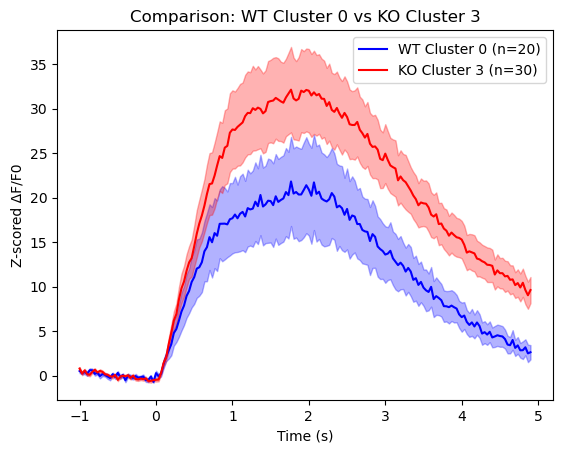

In [6]:
wt_cluster = 0  # <-- change this to the WT cluster index you want to compare
ko_cluster = 3  # <-- change this to the KO cluster index you want to compare

rclust.compare_clusters_traces(wt_cluster, ko_cluster, cluster_data, time, xticks=xticks, attr=attr, save_path=save_path, fig_name=fig_name, show=True)

## Cluster WT and KO together

In [7]:
#To determine the ideal number of clusters
norm_traces = np.concatenate(normalized_traces_groups, axis=0)
rclust.find_nb_clusters(norm_traces, max_clusters=max_clusters, save_path=save_path, fig_name=fig_name, show=False)

(np.int64(5), np.int64(5))

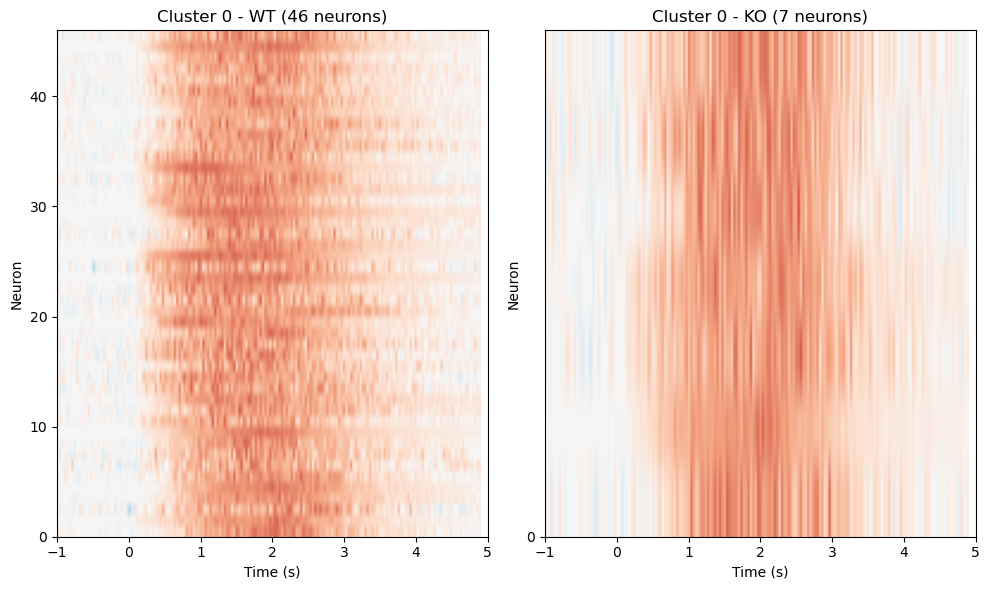

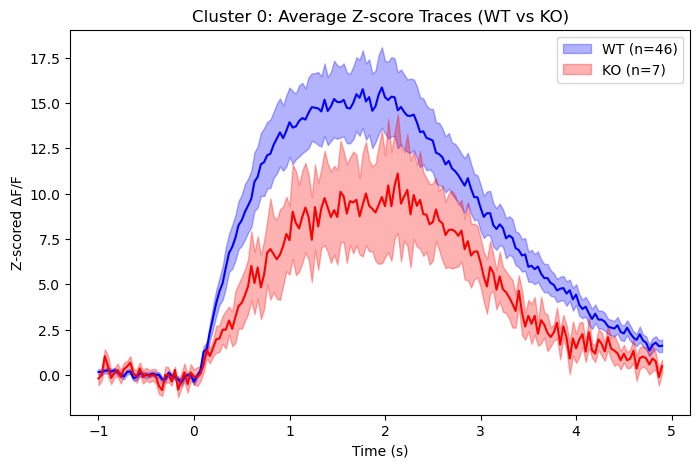

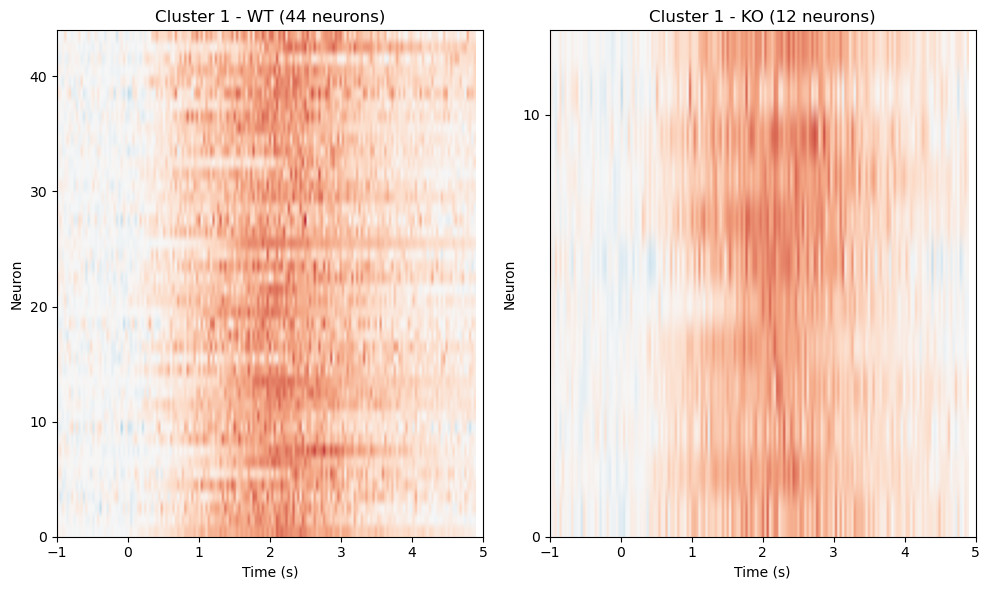

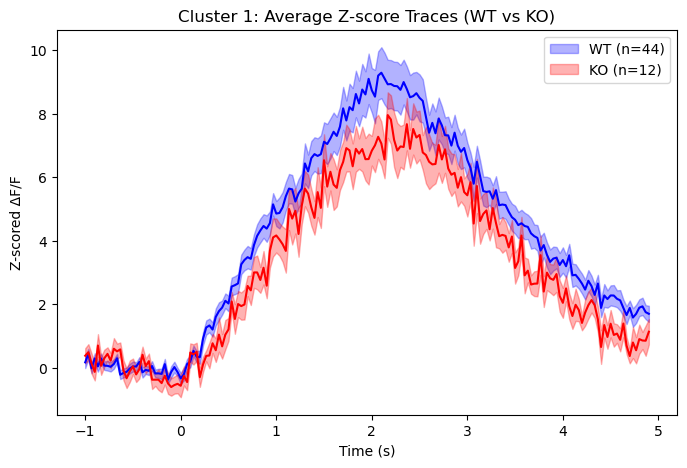

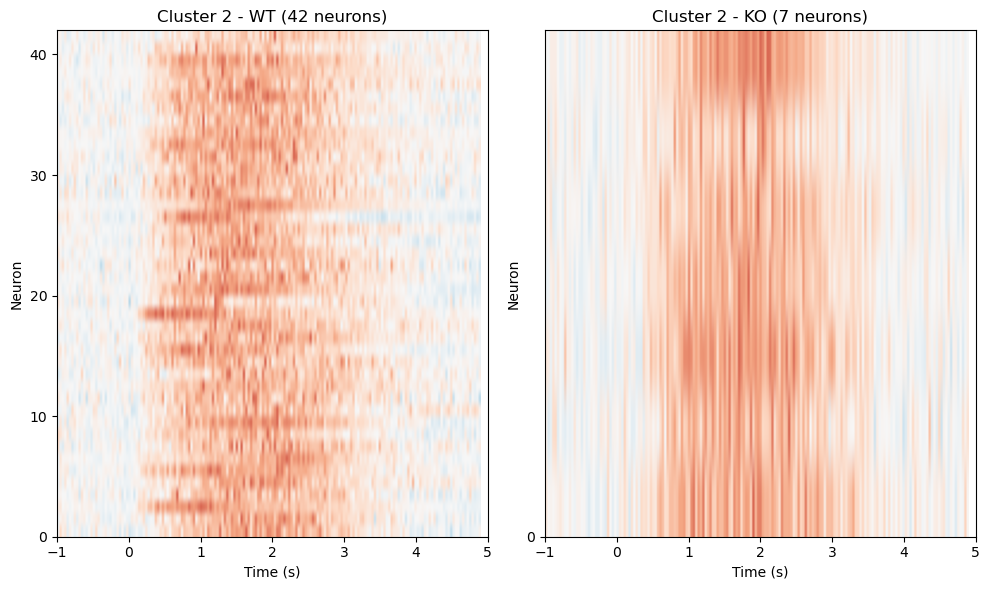

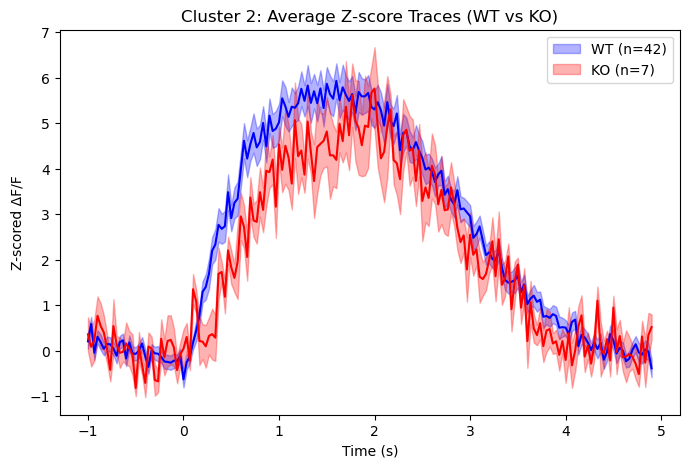

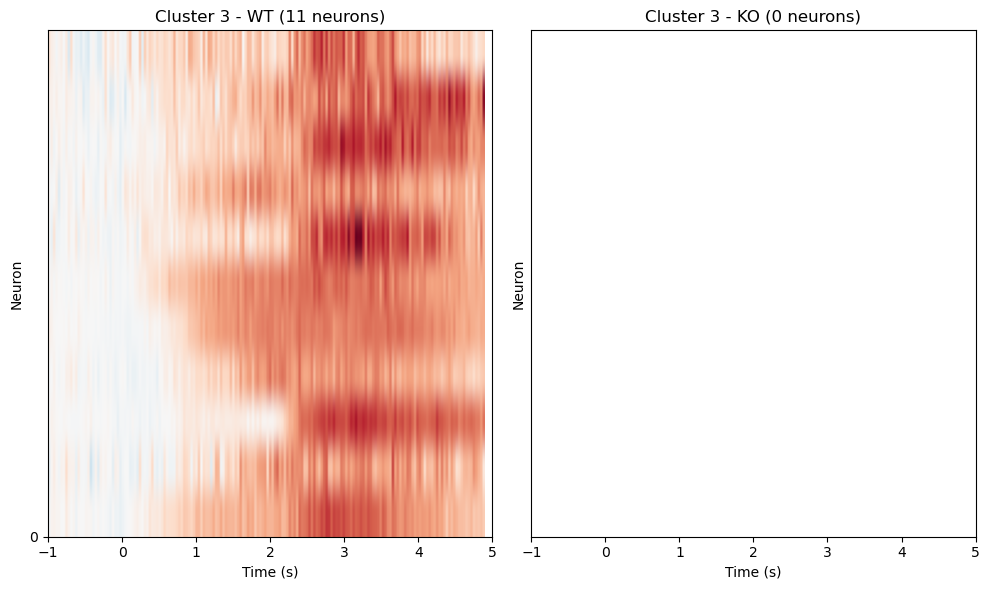

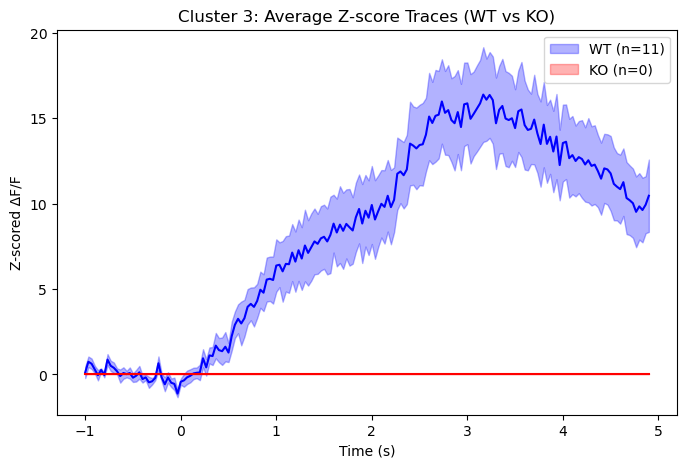

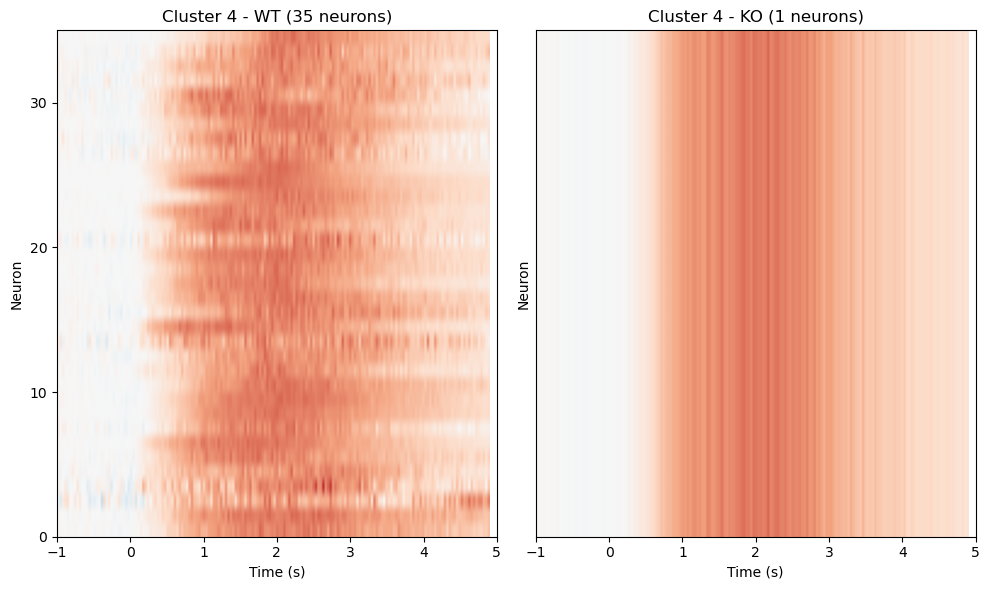

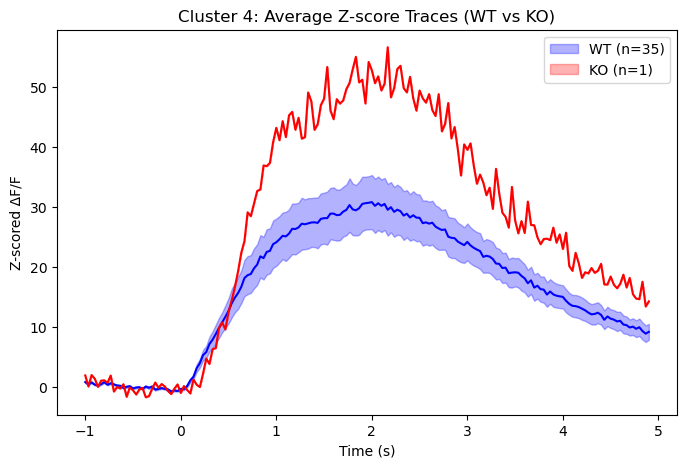

In [8]:
# Set number of clusters for joint clustering
n_clusters_joint = 5  # choose based on elbow/Dunn index as before

#------------------- Run KMeans clustering on the combined data
kmeans = KMeans(n_clusters=n_clusters_joint, n_init=50).fit(norm_traces)
cluster_labels = kmeans.labels_

all_traces = np.concatenate(single_traces_groups, axis=0)
group_labels = np.array(['WT'] * all_neurons_groups[groups_id['WT']] + ['KO'] * all_neurons_groups[groups_id['KO']])

# Time axis
time = (np.arange(all_traces.shape[1]) / frame_rate) - 1
xticks = np.arange(-1, time[-1] + 1, 1)

# For storing cluster data
joint_cluster_data = {}
wt_cluster_counts = np.zeros(len(np.unique(cluster_labels)), dtype=int)
ko_cluster_counts = np.zeros(len(np.unique(cluster_labels)), dtype=int)

# Plot per-cluster average traces for WT and KO
for k in range(n_clusters_joint):

    idx_cluster = np.where(cluster_labels == k)[0]
    wt_cluster_counts[k] = np.sum(group_labels[idx_cluster] == 'WT')
    ko_cluster_counts[k] = np.sum(group_labels[idx_cluster] == 'KO')

    idx_wt = idx_cluster[group_labels[idx_cluster] == 'WT']
    idx_ko = idx_cluster[group_labels[idx_cluster] == 'KO']
    traces_wt_k = all_traces[idx_wt]
    traces_ko_k = all_traces[idx_ko]
    mean_wt = np.mean(traces_wt_k, axis=0) if len(idx_wt) > 0 else np.zeros(all_traces.shape[1])
    sem_wt = stats.sem(traces_wt_k, axis=0) if len(idx_wt) > 1 else np.zeros(all_traces.shape[1])
    mean_ko = np.mean(traces_ko_k, axis=0) if len(idx_ko) > 0 else np.zeros(all_traces.shape[1])
    sem_ko = stats.sem(traces_ko_k, axis=0) if len(idx_ko) > 1 else np.zeros(all_traces.shape[1])
    joint_cluster_data[k] = {
        'WT': {'mean': mean_wt, 'sem': sem_wt, 'n': len(idx_wt)},
        'KO': {'mean': mean_ko, 'sem': sem_ko, 'n': len(idx_ko)}
    }

    # Plot raster plots
    rclust.plot_raster_cluster_group(k, norm_traces, idx_wt, idx_ko, time, xticks, save_path, fig_name, show=True)
    # Plot traces
    rclust.plot_avg_cluster_traces_group(k, joint_cluster_data[k], time, xticks, save_path, fig_name, show=True)

In [9]:
# Normalize to percentages
wt_percentages = 100 * wt_cluster_counts / np.sum(group_labels == 'WT')
ko_percentages = 100 * ko_cluster_counts / np.sum(group_labels == 'KO')
cluster_proportions = {
    'WT': wt_percentages,
    'KO': ko_percentages
}
print(cluster_proportions)

# Plot pie chart for WT
rclust.pie_chart_clusters(wt_percentages, n_clusters_joint, 'WT', save_path, fig_name, show=False)

# Plot pie chart for KO
rclust.pie_chart_clusters(ko_percentages, n_clusters_joint, 'KO', save_path, fig_name, show=False)

{'WT': array([25.84269663, 24.71910112, 23.59550562,  6.17977528, 19.66292135]), 'KO': array([3.93258427, 6.74157303, 3.93258427, 0.        , 0.56179775])}
